# Data Curation and Analysis: The Universities in the United States

The goal of this project is to scrape Wikipedia and create a data set and then analyze that set. The page scraped is https://en.wikipedia.org/wiki/Lists_of_American_universities_and_colleges and the pages linked on it that refer to states and territories of the USA. The data scraped is a table that records colleges and some of their attributes. The criteria for the tables scraped is: describes current institutions (graduate or undergraduate) that are in state and accredited. To scrape the data, Wikipedia API (https://pypi.org/project/Wikipedia-API/) and Beautiful Soup (https://www.crummy.com/software/BeautifulSoup/bs4/doc/) was used. For analysis, Pandas (https://pandas.pydata.org/docs/) and NumPy (https://numpy.org/doc/) were used.

Cell 1: Imports all necessary libraries: WikipediaAPI, BeautifulSoup, Pandas, Requests, HTML5Lib, and NumPy. If there is an error in the importing, annoconda will install the library and then import it.

In [1]:
try:
    import wikipediaapi
    from bs4 import BeautifulSoup
    import pandas
    import requests
    import html5lib
    import numpy
except:
    import sys
    !conda install --yes --prefix {sys.prefix} wikipediaapi
    !conda install --yes --prefix {sys.prefix} BeautifulSoup
    !conda install --yes --prefix {sys.prefix} pandas
    !conda install --yes --prefix {sys.prefix} requests
    !conda install --yes --prefix {sys.prefix} html5lib
    !conda install --yes --prefix {sys.prefix} numpy
    import wikipediaapi
    from bs4 import BeautifulSoup
    import pandas
    import requests
    import html5lib
    import numpy

Cell 2: Intializes WikipediaAPI and sets default language to English. Defines a function (summon_page) that summons a page and checks if it exists (if it does not, it prints an error message), then returns the page using the WikipediaAPI. Defines our main reference page (main_page).

In [2]:
wiki_wiki = wikipediaapi.Wikipedia("en")
def summon_page(page_name):
    page=wiki_wiki.page(page_name)
    if page.exists()==False:
        print("Error",page_name,"Page Exists: %s" % page.exists())
    return page
main_page=summon_page("Lists of American universities and colleges")

Cell 3: Defines a function (relevant_links) that extracts the relevant links from our main reference page using WikipediaAPI. Defines a list (main_links) of the names of the pages that will be processed.

In [3]:
def relevant_links(page):
        links = page.links
        result=[]
        for title in links.keys():
            if "List of colleges and universities" in title:
                result.append(title)
        return result
main_links=relevant_links(main_page)

Cell 4: Defines a list (urls_to_extract) of the urls that will be processed. Removes a site that will cause duplicated data.

In [4]:
urls_to_extract=[]
for page_name in main_links:
    underscore_name=page_name.replace(" ","_")
    temp_page=summon_page(underscore_name)
    full_url=temp_page.fullurl
    urls_to_extract.append(full_url)
urls_to_extract=list(dict.fromkeys(urls_to_extract))
urls_to_extract.remove(
    'https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_the_United_States_by_endowment')

Cell 5: Defines an array (states_and_territories) of state and territory names that corresponds with the urls_to_extract list. Cleans state and territory names for easier use and better readability in the future. Removes "List of colleges and universities in the United States by endowment", as this data will lead to repeated institutions (data points). This is the state/territory name extracted from the site removed from urls_to_extract in Cell 4.

In [5]:
states_and_territories=[]
for page_name in main_links:
    state_name=page_name.split("List of colleges and universities in ")[1]
    state_name=state_name.split("(")[0]
    state_name=state_name.replace("the ","")
    state_name=state_name.strip()
    if state_name=="United States by endowment":
        break
    states_and_territories.append(state_name)
states_and_territories=list(dict.fromkeys(states_and_territories))

Cell 6: Defines a list (all_dataframes) of lists, where the lists are all the dataframes for each state/territory. This list will look like: all_dataframes=[[state_1_dataframes],[state_2_dataframes]...] where each state dataframe will look like state_1_dataframe=[[dataframe_1],[dataframe_2]...]. Hence, this is a list of lists.

In [6]:
all_dataframes=[]
for url in urls_to_extract:
    all_state_data_frames=pandas.read_html(url)
    all_dataframes.append(all_state_data_frames)

Cell 7: Defines a list (raw_dataframe_collection) where all raw dataframes will be stored. Defines the first dataframe in raw_dataframe_collection as raw_dataframe, then combines all other dataframes in raw_dataframe_collection with it usign pandas. Exports raw_dataframe to a csv file named "Raw_Data:_Universities_in_United_States.csv" incase the raw data is needed.

In [7]:
raw_dataframe_collection=[]
for state_frames in all_dataframes:
    for dataframe in state_frames:
        raw_dataframe_collection.append(dataframe)
raw_dataframe=raw_dataframe_collection[0]
for dataframe in raw_dataframe_collection[1:]:
    raw_dataframe=pandas.concat([raw_dataframe,dataframe],ignore_index=True)
raw_dataframe.to_csv("Raw_Data:_Universities_in_United_States.csv")

Cell 8: Defines a function (clean_column_name) that cleans column names. Ex: "Enrollment (Fall 2022)" and "Enrollment (2021)" -> "Enrollment". This is necessary, as the tables extracted from Wikipedia are not standardized in the way they portray data, and this helps to standardize them. 

Note: This will cause a sense of false simplicity in the data, especially in the example given above. 

In [8]:
def clean_column_name(column_name):
    column_name=str(column_name)
    if "(" in column_name:
        column_name=column_name.split("(")[0]
    if "[" in column_name:
        column_name=column_name.split("[")[0]
    return column_name

Cell 9: Creates a dicitonary (header_state_dictionary) that will store a list of the list of the column names for each dataframe extracted for each state in a dictionary[state]=[[table1_column_names],[table2_column_names]...] format. Creates a list (all_headers) that will store all of the headers for future use. Extracts all relevant table headers busing BeautifulSoup:
    
First, all "th" tags (refered to as headers aftwerwards) are found and stored in a list (potential_headers), then two lists (remove_headers and also_remove_headers) store all headers which need to be removed. These headers are ones where scope="row", as these are the data in the left-most column in Wikipedia tables, and ones where id="navbox-title", as these are used as the dynamic references found at the bottom of most Wikipedia pages. Headers from remove_headers and also_remove_headers are removed from potential_headers, then a list is defined (uncleaned_headers). The text in the headers in potential_headers are extracted using BeautifulSoup (Ex: (th)"Header Text"(/th) -> "Header Text") and appended to uncleaned_headers. The headers in uncleaned_headers are cleaned using clean_column_name (from Cell 8), then stored in a list (clean_table_headers). For each table, clean_table_headers is appended to a list (state_headers) which will store lists of clean headers for each state/territory and then redefined as an empty list. After all tables for each state have been processed, state_headers is added to header_state_dictionary as the value for its corresponding state name. 
    
Removes duplicates from all_headers.

In [9]:
header_state_dictionary={}
all_headers=[]
for url in urls_to_extract:
    opened_webpage=requests.get(url)
    bs_page=BeautifulSoup(opened_webpage.content,"html.parser")
    tables=bs_page.find_all("table")
    state_headers=[]
    state_name=states_and_territories[urls_to_extract.index(url)]
    for table in tables:
        potential_headers=table.find_all("th")
        remove_headers=table.find_all(scope="row")
        also_remove_headers=table.find_all("th","navbox-title")
        for header in remove_headers:
            while header in potential_headers:
                potential_headers.remove(header)
        for header in also_remove_headers:
            while header in potential_headers:
                potential_headers.remove(header)
        uncleaned_headers=[]
        for header in potential_headers:
            header=str(header)
            soup=BeautifulSoup(header,"html.parser")
            header=soup.get_text(strip=True)
            uncleaned_headers.append(header)
        clean_table_headers=[]
        for header in uncleaned_headers:
            header=clean_column_name(header)
            clean_table_headers.append(header)
            all_headers.append(header)
        state_headers.append(clean_table_headers)
    header_state_dictionary[state_name]=state_headers
all_headers=list(dict.fromkeys(all_headers))

Cell 10: Defines a list of strings (remove_headers) in the list all_headers that are not useful, so that they can be removed. Defines a copy of all_headers (headers_for_use). Removes strings in remove_headers from headers_for_use.

In [10]:
remove_headers=["Notes","Ref","County","Profit","Affiliation","Institution Focus","Full Time Residency Percentage",
                "Part Time Residency Percentage","Ref.","Education in theUnited States","Summary","Issues",
                "Levels of education","Primary Campus Location","Campus size as of 2018",
                "List of Georgia Satellite Campuses as of 2016","Non-profit status","Carnegie size classification",
                "Average SAT","Average GPA of entering freshman","6-year graduation rates",
                "First-time freshman retention rate ","Rank","Federal research grant award",
                "Totalresearch expenditureFY 2009","Institution research funds ","Economic impact",
                "Number of GRA Eminent Scholars","Number ofGRA VentureLabcompanies",
                "Number ofCenters of Research Excellence","Number ofRhodes Scholars","Number ofMarshall Scholars",
                "Number of Fulbright scholars ","Number ofTruman Scholars","Mascot","Abbreviation","Total",
                "$3.35 billion","122,496","Cite","AverageSATs","Fisher College","Atlantic Union College",
                "Hallmark Institute of Photography","Pine Manor College","Queen of Apostles Seminary",
                "School of the Museum of Fine Arts, Boston","Wheelock College","MA*","Forbes","Employee Size",
                "System","Previous Names","Address","Other Names and Notes",
                "Association of Advanced Rabbinical and Talmudic Schools",
                "Association of Theological Schools in the United States and Canada",
                "Middle States Commission on Higher Education","New Jersey Commission on Higher Education",
                "History","Notes/Refs","","Education in Puerto Rico","Primary and secondary school",
                "Higher education","Non-profit organizations","Fate","Campus acreage","Freshman acceptance rate",
                "Research expenditures ","U.S. Newsranking","Campusacreage","Researchexpenditures",
                "Carnegie sizeclassification","Branches and Campuses","Other branches","NewU University",
                "Main branch","Male\xa0%/Female\xa0%","16th State Board of Education","General details"]
headers_for_use=all_headers.copy()
for header in remove_headers:
    headers_for_use.remove(header)

Cell 11: Defines a dictionary (header_dicitonary) which will store the names of column names that describe the same data and the name which will be used in the final combined dataframe in a header_dictionary[final_table_column_name]=[all_other_column_names] format. Defines lists (institution_names, location_names, type_names, enrollment_names, founded_names, accreditation_names, control_names, athletics_names, public_or_private_names, and endowment_names) that store other possible names of their respective columns. The first name in each of these lists is the name that will be used in the final dataframe. Defines the lists (listed 2 sentences prior) as the values for their respective column names (explained in the last sentence). Defines a list (ordered_headers) that contains the final column names in the order desired for the final dataframe. 
    
Note: "State" is added here even though it does not have a list of other names and is not in the header_dictionary because it will be added to each table in a later cell. Currently, we know which state each table belongs to, as tables for each state are in a list together in all_dataframes, and the indexes of all_dataframes and states_and_territories, meanign one could easily find the state/territory name for a table.

In [11]:
header_dictionary={}
institution_names=["Institution","School","Name"]
location_names=["Location","City","Campus Locations","Main location"]
type_names=["Type","Carnegie Classification","2-Year/4-Year","USG Designation","Carnegie basic classification",
            "Type ","classification","Carnegie classification","Carnegieclassification",
            "Carnegie basicclassification"]
enrollment_names=["Enrollment","Undergraduate enrollment", "Graduate enrollment","Fall 2020 Enrollment Head count",
                  "2008 Full-time equivalent students","Graduate studentenrollment ","Total students",
                  "Undergraduate enrollment","Graduate enrollment","Undergraduateenrollment","Graduateenrollment",
                  "Enrollment ","Enrollments","Student population"]
founded_names=["Founded","Established","Year Founded"]
accreditation_names=["Accreditation", "Accrediting or approving agency"]
control_names=["Control"]
closed_names=["Closed","Defunct"]
athletics_names=["Athletics","Athletic Affiliation","Conference"]
public_or_private_names=["Public/Private"]
endowment_names=["Endowment funds","Endowment"]
header_dictionary["Institution"]=institution_names
header_dictionary["Location"]=location_names
header_dictionary["Type"]=type_names
header_dictionary["Enrollment"]=enrollment_names
header_dictionary["Founded"]=founded_names
header_dictionary["Accreditation"]=accreditation_names
header_dictionary["Control"]=control_names
header_dictionary["Closed"]=closed_names
header_dictionary["Athletics"]=athletics_names
header_dictionary["Public/Private"]=public_or_private_names
header_dictionary["Endowment"]=endowment_names
ordered_headers=["Institution","State","Location","Type","Enrollment","Accreditation","Public/Private","Endowment",
                 "Athletics","Founded","Closed","Control"]

Cell 12: Defines a list of lists (partly_cleaned_dataframes) of useful dataframes. Iterates through all states and territories' dataframes in all_dataframes and removes dataframes that don't have data about institutions. This is necessary, as Wikipedia pages will have interactive "references" sections that are actually tables in html (as mentioned earlier). Dataframes that don't have data about institutions will be empty since their headers were removed earlier. 
    
Note: all changes to dataframes in this cell occurr in place.

In [12]:
index=0
partly_cleaned_dataframes=[]
for all_state_dataframes in all_dataframes:
    state_name=list(header_state_dictionary.keys())[index]
    state_headers=header_state_dictionary[state_name]
    cleaned_state_dataframes=[]
    for header_set in state_headers:
        if header_set==[]:
            dataframe_index=state_headers.index(header_set)
            all_state_dataframes[dataframe_index]=[]
            state_headers[dataframe_index]="x"
    for dataframe in all_state_dataframes:
        if type(dataframe)!=list:
            cleaned_state_dataframes.append(dataframe)
    partly_cleaned_dataframes.append(cleaned_state_dataframes)
    index+=1

Cell 13: Iterates through column names in dataframes and finds if there is an equivalent name using the header_dictionary. Renames columns if name is not already a name chosen for the final dataframe.

Note: all changes to dataframes in this cell occurr in place.

In [13]:
for state_frames in partly_cleaned_dataframes:
    for dataframe in state_frames:
        uncleaned_column_names=list(dataframe.keys())
        renaming_dictionary={}
        for column_name in uncleaned_column_names:
            clean_name=clean_column_name(column_name)
            if clean_name in header_dictionary.keys():
                renaming_dictionary[column_name]=clean_name
            else:
                for key in header_dictionary.keys():
                    if clean_name in header_dictionary[key]:
                        renaming_dictionary[column_name]=key
        dataframe.rename(columns=renaming_dictionary,inplace=True)

Cell 14: Iterates through dataframes, removes all columns which are not in ordered_headers, keeping only columns which will be in the final dataframe.

Note: all changes to dataframes in this cell occurr in place.

In [14]:
for state_frames in partly_cleaned_dataframes:
    for dataframe in state_frames:
        for column_name in dataframe.keys():
            if column_name not in ordered_headers:
                dataframe.drop(column_name,inplace=True,axis=1)

Cell 15: Defines a function (clean_data_point) which cleans and returns data points to make them more standardized and analyze-able.

In [15]:
def clean_data_point(data_point):
    data_point=str(data_point)
    data_point=clean_column_name(data_point)
    data_point=data_point.strip()
    return data_point

Cell 16: Iterates through dataframes and cleans datapoints using clean_data_point and pandas. Redefines the dataframe as the cleaned dataframe, essentially making the transformation of the dataframe in place. 

Note: n is the index corresponding to the state for which dataframes are being processed. i is the index corresponding to the dataframe which is being processed.

In [16]:
n=0
for state_frames in partly_cleaned_dataframes:
    i=0
    for dataframe in state_frames:
        cleaned_dataframe=dataframe.applymap(clean_data_point,na_action="ignore")
        partly_cleaned_dataframes[n][i]=cleaned_dataframe
        i+=1
    n+=1

Cell 17: Iterates through dataframes and finds dataframes where there are two columns with the same name. Adds their indexes to a list (column_compilation).

This only happens with the columns "Athletics" and "Enrollment" for this data set. This happens because some tables have enrollment data split into undergraduate and graduate enrollment, which is then relabeled as "Enrollment" by Cell 13. 

Renames the columns with the same name so that they are distinguishable. Redefines the dataframes at their index in partly_cleaned_dataframes so that all transformations are essentially in place.

Note: n is the index corresponding to the state for which dataframes are being processed. i is the index corresponding to the dataframe which is being processed.

In [17]:
n=0
column_compilation=[]
for state_frames in partly_cleaned_dataframes:
    i=0
    for dataframe in state_frames:
        column_names=list(dataframe.keys())
        columns = []
        count = 1
        column_change=False
        for column_name in column_names:
            if column_names.count(column_name)>1:
                column_change=True
                columns.append(f'{column_name}_{count}')
                count+=1
            else:
                columns.append(column_name)
        if column_change:
            dataframe.columns = columns
            column_compilation.append([n,i])
        i+=1
    n+=1

Cell 18: Iterates through dataframes with two columns that need to be combined (using the indexes for these columns stored in column_compilation). Combines the data in each column and cleans it (if enrollment data, to change to a numeric type), adding the resulting column to the dataframe, while dropping the two columns used. 

Note: changes to dataframes in this cell are in place.

In [18]:
for dataframe_indexes in column_compilation:
    dataframe=partly_cleaned_dataframes[dataframe_indexes[0]][dataframe_indexes[1]]
    if "Enrollment_1" in dataframe.keys():
        dataframe["Enrollment"]=dataframe["Enrollment_1"]+" "+dataframe["Enrollment_2"]
        dataframe.drop("Enrollment_1",inplace=True,axis=1)
        dataframe.drop("Enrollment_2",inplace=True,axis=1)
        enrollment_data=[]
        enrollment_column=dataframe["Enrollment"]
        for data in enrollment_column:
            if data=="nan":
                enrollment_data.append(data)
            elif type(data) is str:
                data_pieces=data.split(" ")
                data=float(data_pieces[0])+float(data_pieces[1])
                enrollment_data.append(data)
            else:
                enrollment_data.append(data)
        dataframe["Enrollment"]=enrollment_data
    if "Athletics_1" in dataframe.keys():
        dataframe["Athletics"]=dataframe["Athletics_1"]+dataframe["Athletics_2"]
        dataframe.drop("Athletics_1",inplace=True,axis=1)
        dataframe.drop("Athletics_2",inplace=True,axis=1)

Cell 19: Iterates through dataframes, finding their respective state using index (n) and adds a column ("State") to them that contains their state name for each institution in the table.

Note: changes to dataframes in this cell are in place.

In [19]:
for n in range(len(partly_cleaned_dataframes)):
    state_name=states_and_territories[n]
    for dataframe in partly_cleaned_dataframes[n]:
        row_num=len(dataframe.index)
        state_column_data=[state_name]*row_num
        dataframe["State"]=state_column_data

Cell 20: Irates through dataframes, checking if every column in ordered_headers (the headers that will be used for the final dataframe) is in the dataframe columns. If not, it adds them, with a NaN value for each institution. 

This happens sometimes, especially with columns like "Endowment" or "Athletics", as not a lot of tables provide that data, so those columns will be missing entirely. Adding them in makes joinng all the tables together easier in the end.

Note: changes to dataframes in this cell are in place.

In [20]:
for state_frames in partly_cleaned_dataframes:
    for dataframe in state_frames:
        for header in ordered_headers:
            if header not in dataframe.keys():
                dataframe[header]=numpy.nan

Cell 21: Iterates through dataframes, reordering their columns to match ordered_headers in order to prepare to merge them all into one final dataframe. Redefines the dataframes at their index in partly_cleaned_dataframes so that all transformations are essentially in place.

In [21]:
n=0
for state_frames in partly_cleaned_dataframes:
    i=0
    for dataframe in state_frames:
        dataframe=dataframe[ordered_headers]
        partly_cleaned_dataframes[n][i]=dataframe
        i+=1
    n+=1

Cell 22: Iterates through dataframes, appending them all to a list (cleaned_dataframes) which stores the final dataframes after they have all been cleaned.

In [22]:
cleaned_dataframes=[]
for state_frames in partly_cleaned_dataframes:
    for dataframe in state_frames:
        cleaned_dataframes.append(dataframe)

Cell 23: Iterates through dataframes in cleaned_dataframes, and combines them all into one data frame: final_dataframe.

In [23]:
final_dataframe=pandas.DataFrame(columns=ordered_headers)
for dataframe in cleaned_dataframes:
    final_dataframe=pandas.concat([final_dataframe,dataframe],ignore_index=True)

Cell 24: Cleans the final_dataframe by dropping all duplicates, removing columns that are full entirely of NaNs and reseting the index. 

Note: all changes to the dataframe in this cell are in place.

In [24]:
final_dataframe=final_dataframe.dropna(axis=1,how="all")
final_dataframe=final_dataframe.drop_duplicates(keep=False)
final_dataframe.reset_index(inplace=True)

Cell 25: Defines a list (final_endowment_data) which will store the final "Endowment" data used in the final_dataframe. Defines a list (second_pieces) of strings that are likely to show up if "Endowment" data is split. Iterates through "Endowment" data, splitting it and changing it into a numeric form. Appends data to final_endowment_data, replacing the "Endowment" data with the list. Ex: "$23 Million" -> 23000000, "790,000" -> 790000

In [25]:
final_endowment_data=[]
second_pieces=["MILLION","BILLION"]
for data in final_dataframe["Endowment"]:
    if type(data) is not str:
        final_endowment_data.append(data)
    else:
        data=data.split("$")[1]
        if " " in data:
            data_pieces=data.split(" ")
        if "xa" in data:
            data_pieces=data.split("xa")
            data_pieces[0]=data_pieces[0][:len(data_pieces[0])-1]
        if "," in data:
            data_pieces=data.split(",")
        if data_pieces[1].upper() not in second_pieces:
            data=data_pieces[0]+data_pieces[1]
            data=pandas.to_numeric(data)
            final_endowment_data.append(data)
        else:
            if data_pieces[1].upper()=="MILLION":
                data=pandas.to_numeric(data_pieces[0])*1000000
                final_endowment_data.append(data)
            else:
                data=pandas.to_numeric(data_pieces[0])*1000000000
                final_endowment_data.append(data)
final_dataframe["Endowment"]=final_endowment_data

Cell 26: Exports the final_dataframe to a csv file named "Universities_in_the_United_States.csv".

In [26]:
final_dataframe.to_csv("Universities_in_the_United_States.csv")

Cell 27: Plot a bar graph of the number of institutions in each state/territory.

<AxesSubplot:title={'center':'Number of Institutions per State or Territory in the United States'}, xlabel='State or Territory', ylabel='Number of Institutions'>

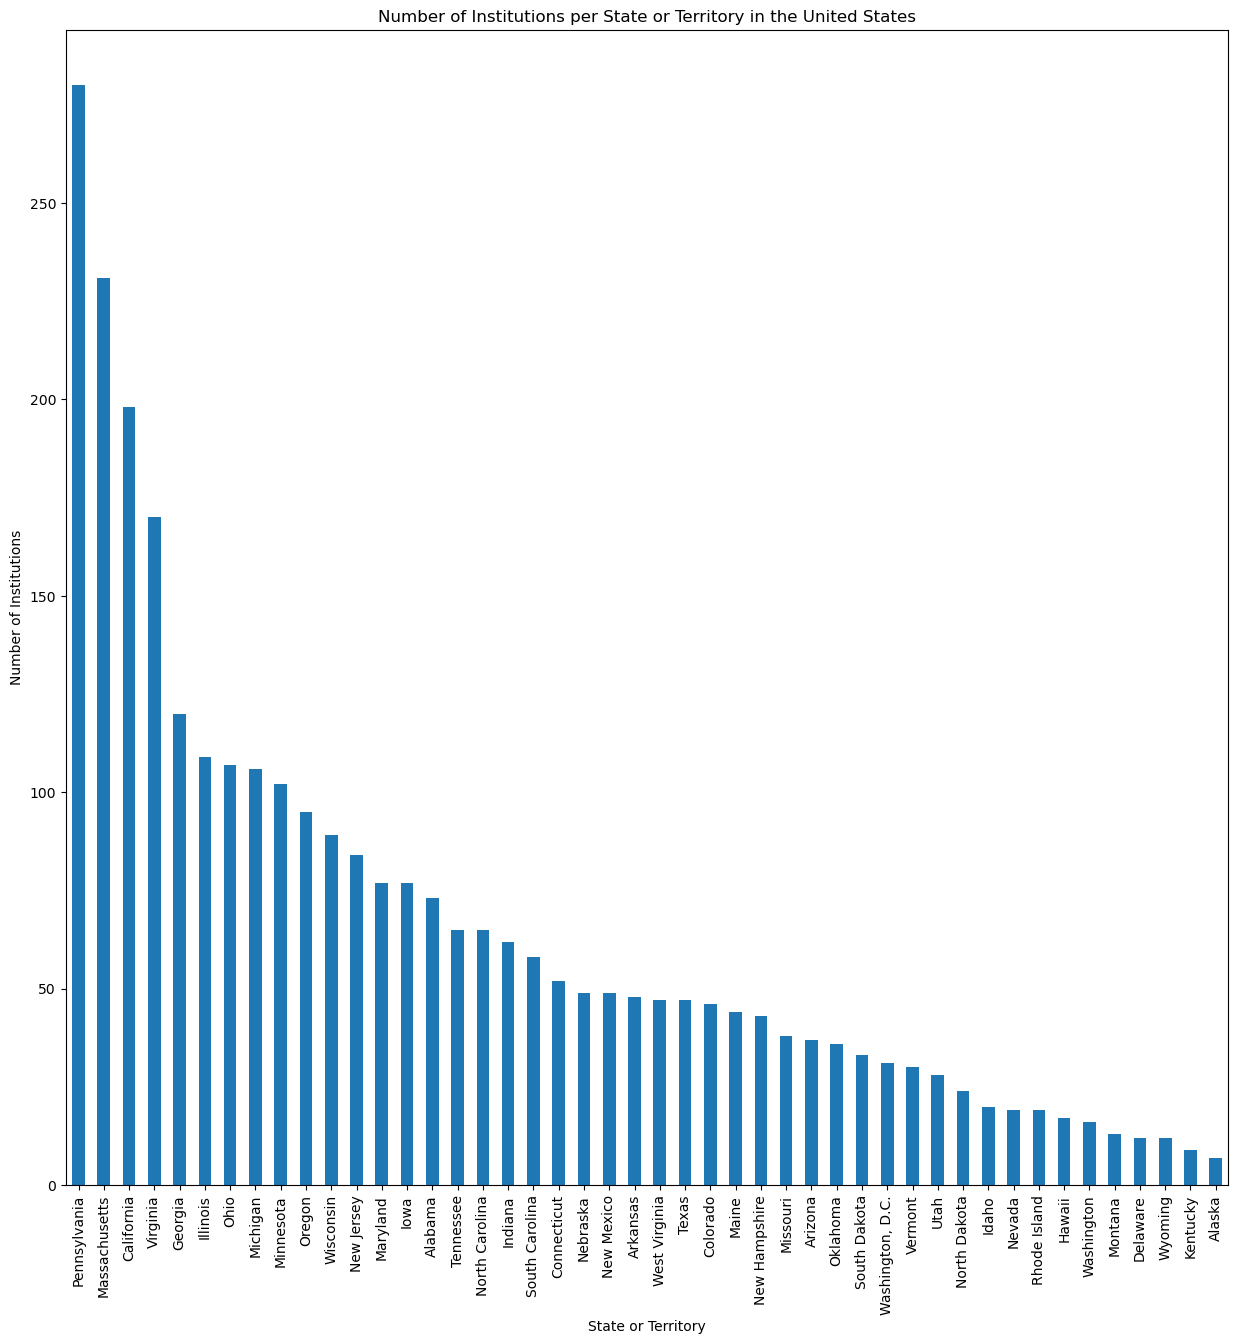

In [27]:
final_dataframe["State"].value_counts().plot(kind="bar",xlabel="State or Territory",ylabel="Number of Institutions",title="Number of Institutions per State or Territory in the United States",figsize=(15,15))

Observations: Pennsylvania has the most institutions, and Alaska has the least (probably because of its smaller population). The states that have the most institutions seem to be on the East Coast and in the North East.

Cell 28: Plots a bar graph of the number of institutions of each type (but only for the first 20 types).

<AxesSubplot:title={'center':'Number of Institutions for the Top 20 Types'}, xlabel='Type of Institution', ylabel='Number of Institutions'>

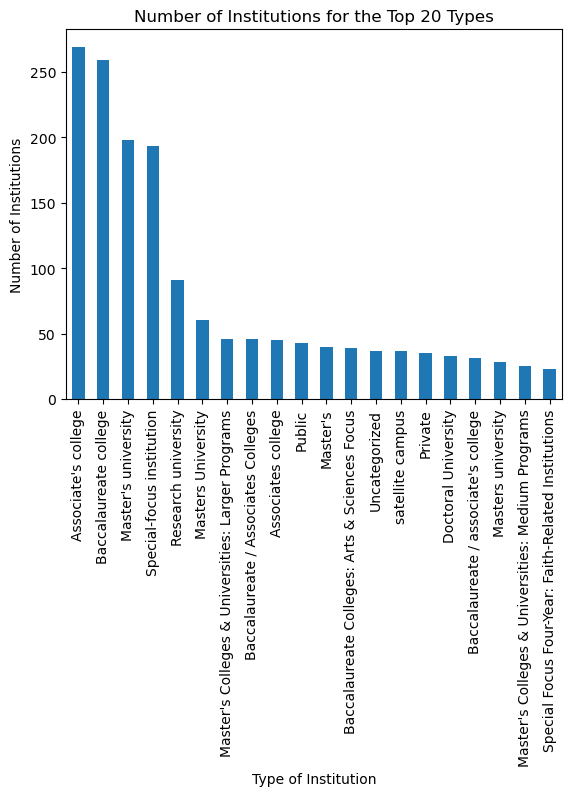

In [28]:
final_dataframe["Type"].value_counts()[:20].plot(kind="bar",xlabel="Type of Institution",ylabel="Number of Institutions",title="Number of Institutions for the Top 20 Types")

Obersvations: There are more Associate's colleges than Baccalaureate colleges, which is surprising consdier the prevalence of the 4-year university narrative in the United States. However, the two seem to present in almost equal amount. There are also quite a lot of special foucs institutions.

Cell 29: Plots a bar graph of the number of institutions for each of the top 10 accreditors.

<AxesSubplot:title={'center':'Number of Institutions for the Top 10 Accreditors'}, xlabel='Accreditation', ylabel='Number of Institutions'>

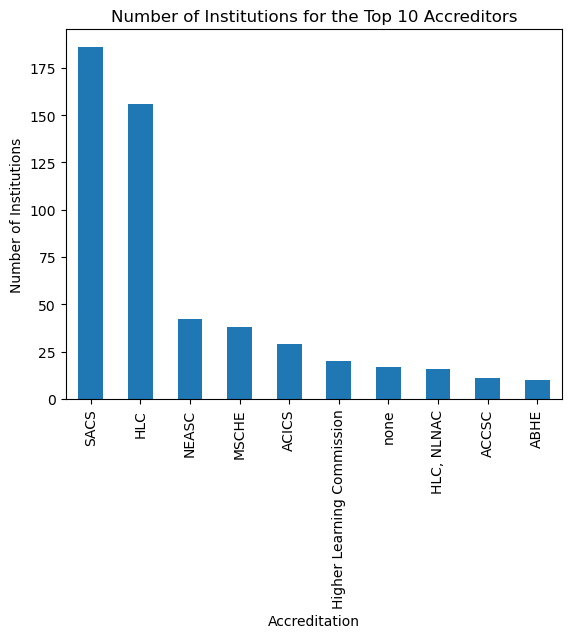

In [29]:
final_dataframe["Accreditation"].value_counts()[:10].plot(kind="bar",xlabel="Accreditation",ylabel="Number of Institutions",title="Number of Institutions for the Top 10 Accreditors")

Observations: The vast majority of institutions are accredited by SACS or HLC. There are a fair amount of institutions which seem to not be accredited (although the "none" result may just be from an error).